<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/main/cnn_adjusted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import matplotlib.pyplot as plt
import random

def plot_random_element(X_train_map):
    index = random.randint(0, len(X_train_map) - 1)  # Pick a random index
    element = X_train_map[index, :, :, 0]  # Retrieve the element

    plt.figure(figsize=(8, 6))
    plt.imshow(element, cmap='viridis', origin='lower')
    plt.title(f"Random Element from X_train_map (Index {index})")
    plt.colorbar(label='Intensity')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.show()


    



In [19]:
def plot5(X_test_map, particle_vector)

  # Plotting random maps with information

  # Select 5 random indices from the test data
  random_indices = np.random.choice(range(X_test_map.shape[0]), size=5, replace=False)

  # Create a subplot with 5 rows and 1 column
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the random indices and plot each map with information
  for i, index in enumerate(random_indices):
      # Get the map and corresponding information
      map_data = X_test_map[index, :, :, 0]
      mass_category = particle_vector[index].mass_category
      ckov = particle_vector[index].ckov
      mip_position = particle_vector[index].mip_position
      momentum = particle_vector[index].momentum
      
      # Plot the map
      axes[i].imshow(map_data, cmap='gray')
      
      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0], mip_position[1], 'ro')
      
      # Set the title with the information
      axes[i].set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}")
      axes[i].axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [16]:
def create_lr_scheduler(num_epochs = 10):

  tf.random.set_seed(42)
  div = num_epochs/4
  print("div =", div)
  print("1e-4 * 10**(epoch/div) = ", 1e-4 * 10**(num_epochs/div))
  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/div)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
  return lr_scheduler


  


def plot_lr(num_epochs = 10, history = None):
  div = num_epochs/4
  lrs = 1e-4 * (10 ** (np.arange(num_epochs)/div))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")
  plt.title("Learning rate vs. loss");

  X_train_mip_position = (98, 2)
Dimensions of the input data:
Training:
  X_train_map = (78, 144, 160, 1)
  X_train_momentum = (78, 1)
  X_train_refractive_index = (78, 1)
  X_train_mip_position = (78, 2)
  y_train = (78, 3)
Testing:
  X_test_map = (20, 144, 160, 1)
  X_test_momentum = (20, 1)
  X_test_refractive_index = (20, 1)
  X_test_mip_position = (20, 2)
  y_test = (20, 3)


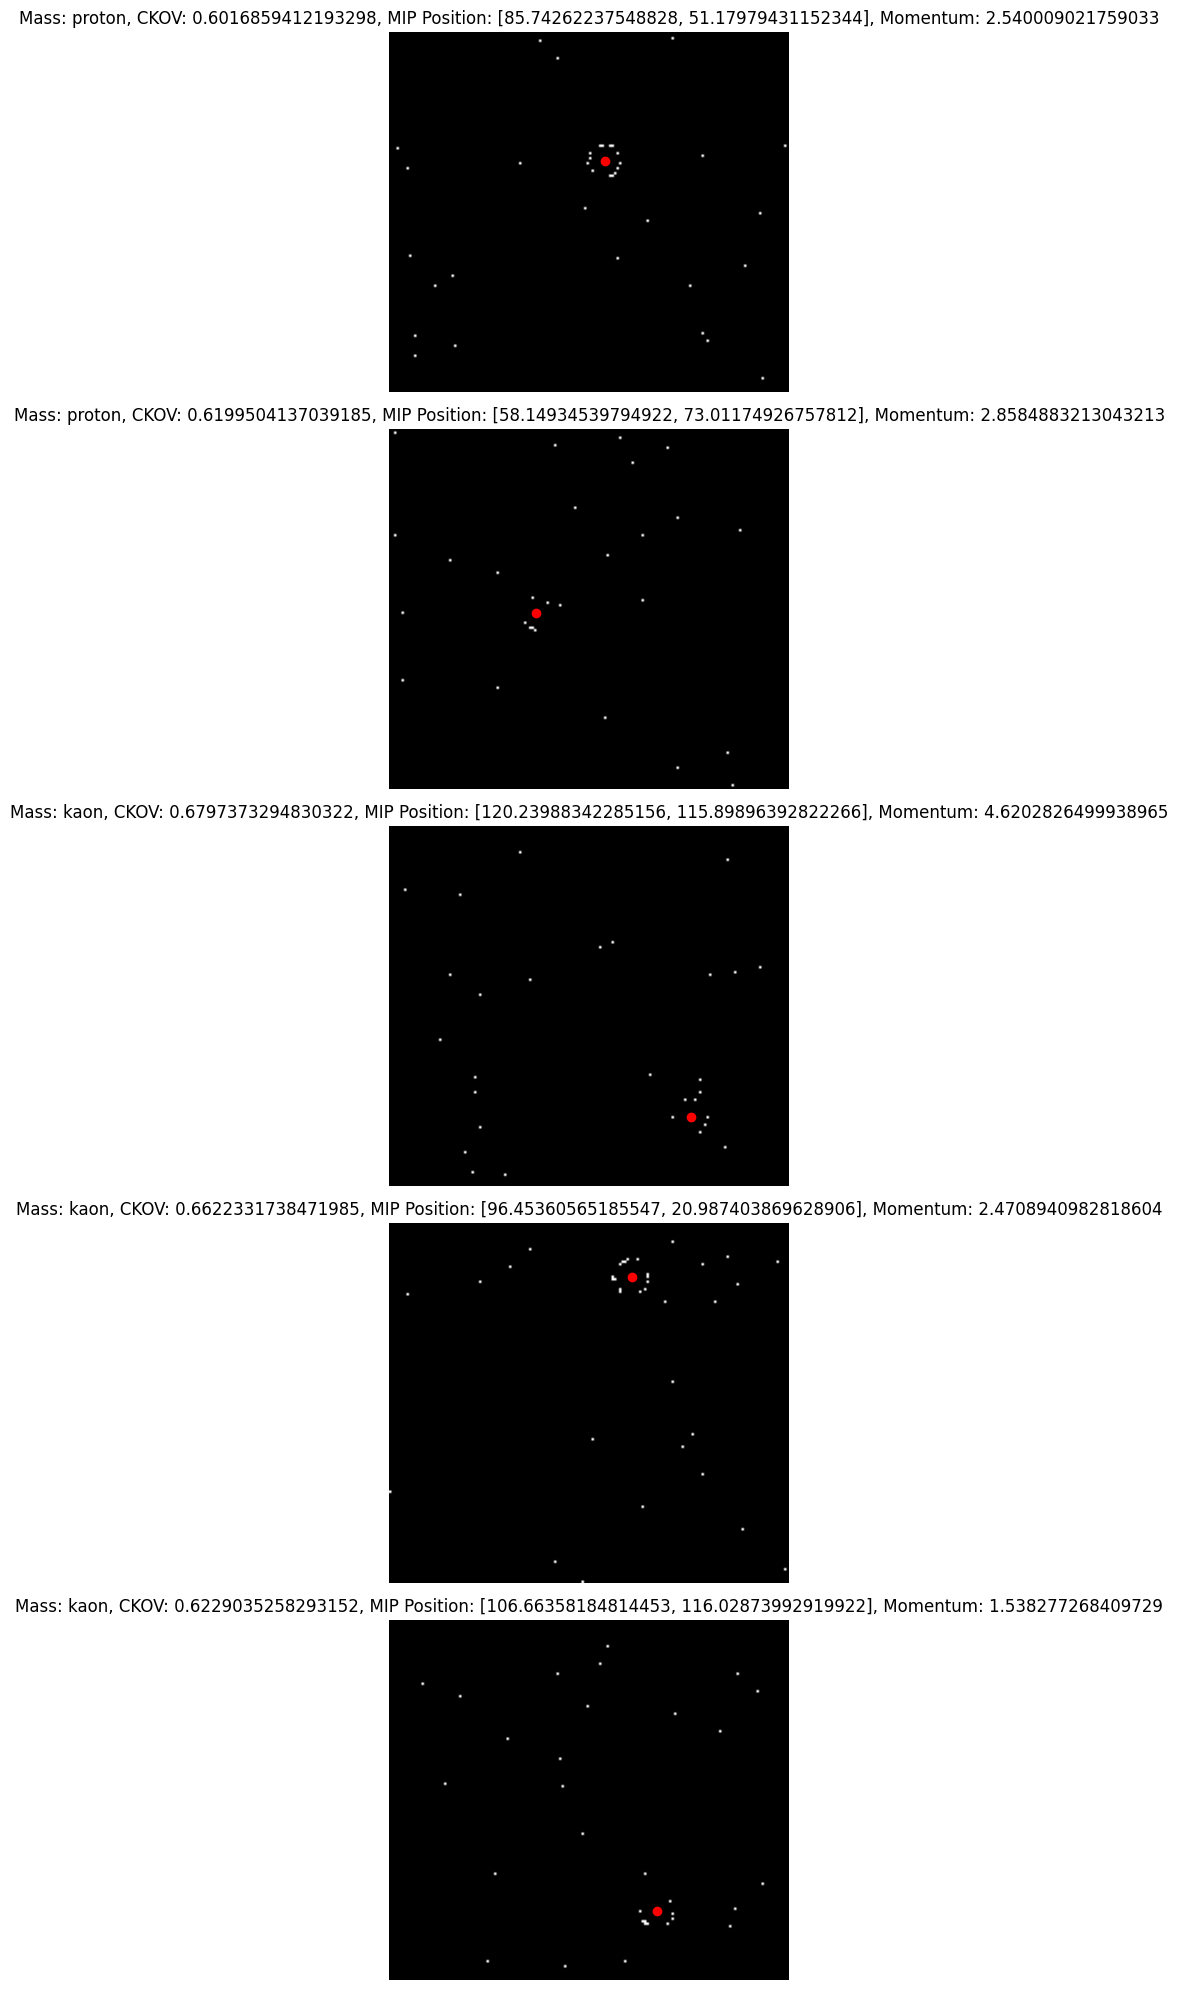

Epoch 1/20
3/3 [==============================] - 4s 179ms/step - loss: 1.3652 - accuracy: 0.3333 - val_loss: 1.6071 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 0s 63ms/step - loss: 1.0499 - accuracy: 0.4744 - val_loss: 1.5084 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 0s 59ms/step - loss: 0.9306 - accuracy: 0.5385 - val_loss: 1.4025 - val_accuracy: 0.4000
Epoch 4/20
3/3 [==============================] - 0s 55ms/step - loss: 0.8519 - accuracy: 0.5769 - val_loss: 1.3215 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 0s 55ms/step - loss: 0.6621 - accuracy: 0.7308 - val_loss: 1.2713 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 0s 55ms/step - loss: 0.6058 - accuracy: 0.8077 - val_loss: 1.2198 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 0s 55ms/step - loss: 0.5222 - accuracy: 0.8718 - val_loss: 1.1896 - val_accuracy: 0.4000
Epoch 8/20
3/3 [==========

In [63]:
from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt


np.set_printoptions(precision=4)


class ParticleDataUtils:
    class ParticleInfo:
        def __init__(self, momentum, mass, energy, refractiveIndex, ckov, filledBins, mip_position):
            self.momentum = momentum
            self.mass = mass
            self.energy = energy
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins
            self.mip_position = mip_position
            self.mass_category = self.infer_mass_category(mass)  # Infer mass category based on mass
            
        @staticmethod
        def infer_mass_category(mass):
            pion_mass = 0.1396
            proton_mass = 0.938
            kaon_mass = 0.4937

            if abs(mass - pion_mass) < 1e-6:
                return "pion"
            elif abs(mass - proton_mass) < 1e-6:
                return "proton"
            elif abs(mass - kaon_mass) < 1e-6:
                return "kaon"
            else:
                return "unknown"

def save_particle_info_to_hdf5(particle_vector, filename):
    with h5py.File(filename, 'w') as file:
        for i, particle in enumerate(particle_vector):
            # Create a group for each particle
            group = file.create_group(f'Particle{i}')

            # Store scalar values
            group.attrs['Momentum'] = particle.momentum
            group.attrs['Mass'] = particle.mass
            group.attrs['Energy'] = particle.energy
            group.attrs['RefractiveIndex'] = particle.refractiveIndex
            group.attrs['Ckov'] = particle.ckov
            group.attrs['MassCategory'] = particle.massCategory  # Save the mass category
            group.attrs['MipPos'] = particle.mip_position  # Save the MIP position X coordinate
            #group.attrs['MipPositionY'] = particle.mip_position[1]  # Save the MIP position Y coordinate


            # Store filledBins to HDF5 file
            group.create_dataset("FilledBins", data=np.array(particle.filledBins, dtype=[('x', 'f'), ('y', 'f')]))

def print_hdf5_items(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}")
    elif isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Attribute):
        print(f"Attribute: {name}")


def load_particle_info_from_hdf5(filename):
    particle_vector = []
    
    with h5py.File(filename, 'r') as file:
        #file.visititems(print_hdf5_items)
        for i, group_name in enumerate(file):
            group = file[group_name]

            # Read scalar values
            momentum = group.attrs['Momentum']
            mass = group.attrs['Mass']
            energy = group.attrs['Energy']
            refractiveIndex = group.attrs['RefractiveIndex']
            ckov = group.attrs['Ckov']
            #mip_position = np.array((group.attrs['MipPositionX'], group.attrs['MipPositionY']))
            mip_position = group['MipPos']
            mip_position = mip_position[...]  # Retrieve the data as a numpy array

            mip_position = mip_position.tolist()  # Convert the numpy array to a list


            #print("load_particle_info_from_hdf5 :  mip_position =", np.array(mip_position).shape)

            # Read filledBins
            filled_bins_dataset = group['FilledBins']
            filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

            filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

            particle_info = ParticleDataUtils.ParticleInfo(
                momentum, mass, energy, refractiveIndex, ckov, filledBins=filled_bins, mip_position=mip_position)

            particle_vector.append(particle_info)

    return particle_vector


def read_particle_data_from_file(filename="particle.h5"):
    drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
    file_path = os.path.join(drive_path, filename)
    particle_vector = load_particle_info_from_hdf5(file_path)
    return particle_vector

# Example usage
filename = 'ParticleInfo.h5'
particle_vector = read_particle_data_from_file(filename)

# Create an empty list to store the map_data for all particles
map_data_list = []

# Create an empty 2D map
map_shape = (144, 160)
map_data = np.zeros(map_shape)

# Iterate over all particles in the particle_vector


X_train_mip_position = []
for i, particle in enumerate(particle_vector):
    # Reset the map_data for each particle
    map_data = np.zeros(map_shape)
    X_train_mip_position.append(np.array(particle.mip_position))

    for entry in particle.filledBins:
        x = int(round(entry[0]))
        y = int(round(entry[1]))
        # Shift the coordinates to the center
        if 0 <= y < map_shape[0] and 0 <= x < map_shape[1]:
            map_data[y, x] = 1

    # Add the map_data to the list
    map_data_list.append(map_data)

# Convert the map_data_list to a NumPy array
map_data_array = np.array(map_data_list)

X_train_mip_position = np.array(X_train_mip_position)

#for a in X_train_mip_position:
#print(f"a {a}")
  #print(f"x {x} y {y}")

# Prepare the training data
X_train_map = map_data_array  # Use the map_data_array as X_train_map
X_train_momentum = np.array([particle.momentum for particle in particle_vector])
X_train_refractive_index = np.array([particle.refractiveIndex for particle in particle_vector])
#X_train_mip_position = np.array([particle.mip_position for particle in particle_vector])#.reshape(-1, 2)
#X_train_mip_position = np.vstack([particle.mip_position for particle in particle_vector])
#map_data_array = np.array(map_data_list)



# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform([particle.mass_category for particle in particle_vector])
y_test_encoded = label_binarizer.transform([particle.mass_category for particle in particle_vector])

# create a scaler object
std_scaler = StandardScaler()

# fit and transform the data
X_train_momentum = X_train_momentum.reshape(-1, 1)
X_train_momentum = std_scaler.fit_transform(X_train_momentum)

X_train_refractive_index = X_train_refractive_index.reshape(-1, 1)
X_train_refractive_index = std_scaler.fit_transform(X_train_refractive_index)


print("  X_train_mip_position =", X_train_mip_position.shape)
X_plot = X_train_map
X_plot = X_plot.reshape(X_train_map.shape[0], X_train_map.shape[1], X_train_map.shape[2], 1)

# Split the data into train and test sets
X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, X_train_mip_position, X_test_mip_position, y_train, y_test = train_test_split(
    X_train_map,
    X_train_momentum,
    X_train_refractive_index,
    X_train_mip_position,
    y_train_encoded,
    test_size=0.2,
    random_state=42
)

# Reshape the input map to include the channel dimension
X_train_map = X_train_map.reshape(X_train_map.shape[0], X_train_map.shape[1], X_train_map.shape[2], 1)
X_test_map = X_test_map.reshape(X_test_map.shape[0], X_test_map.shape[1], X_test_map.shape[2], 1)

# Define input shapes
map_shape = X_train_map.shape[1:]
momentum_shape = (1,)
refractive_index_shape = (1,)
mip_position_shape = (2,)

# Define inputs
map_input = Input(shape=map_shape, name='map_input')
momentum_input = Input(shape=momentum_shape, name='momentum_input')
refractive_index_input = Input(shape=refractive_index_shape, name='refractive_index_input')
mip_position_input = Input(shape=mip_position_shape, name='mip_position_input')

# Define convolutional layers for the map input
conv1 = Conv2D(32, (5, 5))(map_input)
conv1 = BatchNormalization()(conv1)
conv1 = tf.keras.activations.relu(conv1)
conv1 = MaxPooling2D((2, 2))(conv1)  # Add max pooling after conv1
conv1 = Dropout(0.2)(conv1)  # Add dropout after max pooling

conv2 = Conv2D(64, (9, 9))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = tf.keras.activations.relu(conv2)
conv2 = MaxPooling2D((2, 2))(conv2)  # Add max pooling after conv2
conv2 = Dropout(0.1)(conv2)  # Add dropout after max pooling

conv3 = Conv2D(16, (11, 11), activation='relu')(conv2)
conv3 = MaxPooling2D((2, 2))(conv3)  # Add max pooling after conv3
conv3 = Dropout(0.1)(conv3)  # Add dropout after max pooling

# Flatten
flat_map = Flatten()(conv3)

# Concatenate map features with other inputs
concat = concatenate([flat_map, momentum_input, refractive_index_input, mip_position_input])

# Define fully connected layers
fc1 = Dense(128)(concat)
fc1 = BatchNormalization()(fc1)
fc1 = tf.keras.activations.relu(fc1)
fc1 = Dropout(0.1)(fc1)  # Add dropout after the first fully connected layer

fc2 = Dense(32)(fc1)
fc2 = BatchNormalization()(fc2)
fc2 = tf.keras.activations.relu(fc2)
fc2 = Dropout(0.1)(fc2)  # Add dropout after the second fully connected layer

output = Dense(3, activation='softmax')(fc2)  # Predicting mass categories

# Define the model
model = Model(inputs=[map_input, momentum_input, refractive_index_input, mip_position_input], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the shapes of the input data
print("Dimensions of the input data:")
print("Training:")
print("  X_train_map =", X_train_map.shape)
print("  X_train_momentum =", X_train_momentum.shape)
print("  X_train_refractive_index =", X_train_refractive_index.shape)
print("  X_train_mip_position =", X_train_mip_position.shape)
print("  y_train =", y_train.shape)
print("Testing:")
print("  X_test_map =", X_test_map.shape)
print("  X_test_momentum =", X_test_momentum.shape)
print("  X_test_refractive_index =", X_test_refractive_index.shape)
print("  X_test_mip_position =", X_test_mip_position.shape)
print("  y_test =", y_test.shape)

# Set the percentage of the training set to plot (e.g., 20%)
percentage_to_plot = 0.05 / 100

# Calculate the number of samples to plot
num_samples = int(X_train_map.shape[0] * percentage_to_plot)

# Create a subplot with the number of rows based on the number of samples
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

# Iterate over the samples and plot each map with information
for i, ax in enumerate(axes):
    # Get the map and corresponding information
    map_data = X_plot[i, :, :, 0]
    mass_category = particle_vector[i].mass_category
    ckov = particle_vector[i].ckov
    mip_position = particle_vector[i].mip_position
    momentum = particle_vector[i].momentum

    # Plot the map
    ax.imshow(map_data, cmap='gray')

    # Add a red dot at the MIP position
    ax.plot(mip_position[0], mip_position[1], 'ro')

    # Set the title with the information
    ax.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



# Train the model
history = model.fit(
    x=[X_train_map, X_train_momentum, X_train_refractive_index, X_train_mip_position],
    y=y_train,
    validation_data=([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position], y_test),
    batch_size=32,
    epochs=20,
    verbose=1
)


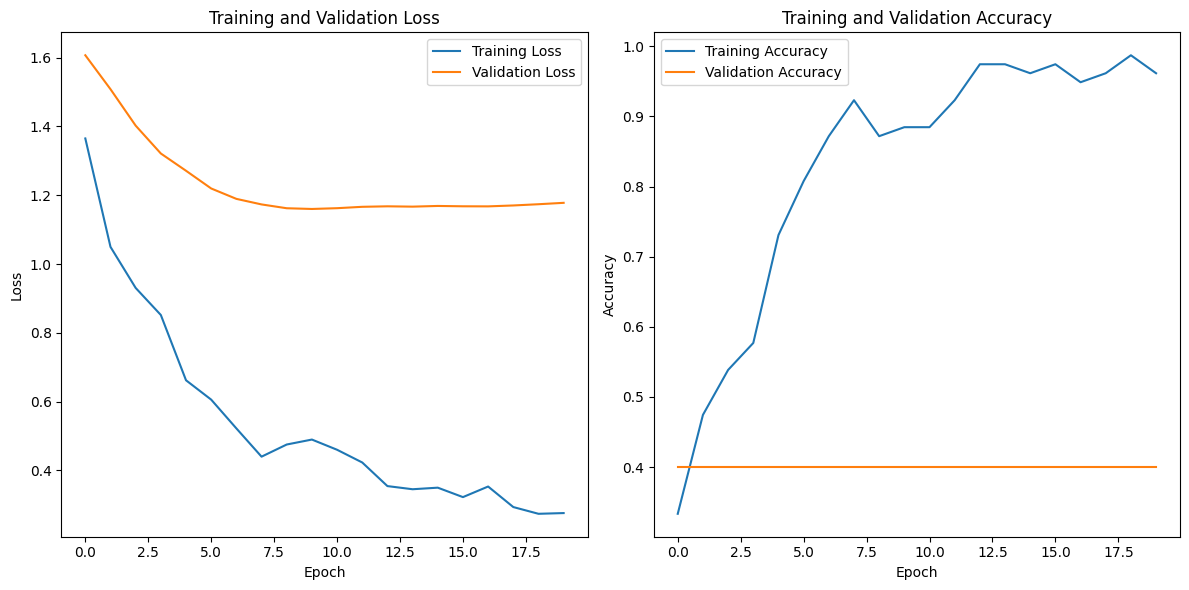

In [64]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Dimensions of the input data:
Training:
  X_train_map = (9871, 144, 160, 1)
  X_train_momentum = (9871, 1)
  X_train_refractive_index = (9871, 1)
  y_train = (9871,)
False
False
False
False
Epoch 1/20
247/247 [==============================] - 18s 53ms/step - loss: 1.3845 - accuracy: 0.3326 - val_loss: 1.1687 - val_accuracy: 0.3306
Epoch 2/20
247/247 [==============================] - 12s 47ms/step - loss: 1.2688 - accuracy: 0.3450 - val_loss: 1.1517 - val_accuracy: 0.3362
Epoch 3/20
247/247 [==============================] - 12s 47ms/step - loss: 1.2143 - accuracy: 0.3568 - val_loss: 1.1249 - val_accuracy: 0.3296
Epoch 4/20
247/247 [==============================] - 12s 47ms/step - loss: 1.1869 - accuracy: 0.3584 - val_loss: 1.1114 - val_accuracy: 0.3514
Epoch 5/20
247/247 [==============================] - 12s 47ms/step - loss: 1.1665 - accuracy: 0.3633 - val_loss: 1.1159 - val_accuracy: 0.3448
Epoch 6/20
247/247 [==============================] - 12s 47ms/step - loss: 1.1469 - accur

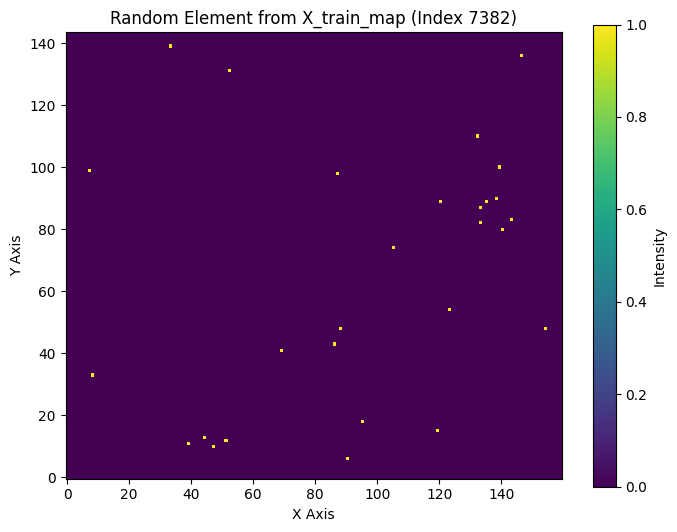

In [8]:
from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

class ParticleDataUtils:
    class ParticleInfo:
        def __init__(self, momentum, mass, energy, refractiveIndex, ckov, filledBins):
            self.momentum = momentum
            self.mass = mass
            self.energy = energy
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins
            self.mass_category = self.infer_mass_category(mass)  # Infer mass category based on mass
            
        @staticmethod
        def infer_mass_category(mass):
            pion_mass = 0.1396
            proton_mass = 0.938
            kaon_mass = 0.4937

            if abs(mass - pion_mass) < 1e-6:
                return "pion"
            elif abs(mass - proton_mass) < 1e-6:
                return "proton"
            elif abs(mass - kaon_mass) < 1e-6:
                return "kaon"
            else:
                return "unknown"

def save_particle_info_to_hdf5(particle_vector, filename):
    with h5py.File(filename, 'w') as file:
        for i, particle in enumerate(particle_vector):
            # Create a group for each particle
            group = file.create_group(f'Particle{i}')

            # Store scalar values
            group.attrs['Momentum'] = particle.momentum
            group.attrs['Mass'] = particle.mass
            group.attrs['Energy'] = particle.energy
            group.attrs['RefractiveIndex'] = particle.refractiveIndex
            group.attrs['Ckov'] = particle.ckov
            group.attrs['MassCategory'] = particle.massCategory  # Save the mass category

            # Store filledBins to HDF5 file
            group.create_dataset("FilledBins", data=np.array(particle.filledBins, dtype=[('x', 'f'), ('y', 'f')]))

def load_particle_info_from_hdf5(filename):
    particle_vector = []
    
    with h5py.File(filename, 'r') as file:
        for i, group_name in enumerate(file):
            group = file[group_name]

            # Read scalar values
            momentum = group.attrs['Momentum']
            mass = group.attrs['Mass']
            energy = group.attrs['Energy']
            refractiveIndex = group.attrs['RefractiveIndex']
            ckov = group.attrs['Ckov']
            #massCategory = group.attrs['MassCategory']  # Load the mass category

            # Read filledBins
            filled_bins_dataset = group['FilledBins']
            filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

            filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

            particle_info = ParticleDataUtils.ParticleInfo(
                momentum, mass, energy, refractiveIndex, ckov, filledBins=filled_bins)

            #particle_info.massCategory = massCategory  # Set the mass category
            
            particle_vector.append(particle_info)

    return particle_vector


def read_particle_data_from_file(filename="particle.h5"):
    drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
    file_path = os.path.join(drive_path, filename)
    particle_vector = load_particle_info_from_hdf5(file_path)
    return particle_vector

# Example usage
filename = 'ParticleInfo.h5'
particle_vector = read_particle_data_from_file(filename)

# Create an empty list to store the map_data for all particles
map_data_list = []

# Create an empty 2D map
map_shape = (144, 160)
map_data = np.zeros(map_shape)

# Iterate over all particles in the particle_vector
for i, particle in enumerate(particle_vector):
    # Reset the map_data for each particle
    map_data = np.zeros(map_shape)

    for entry in particle.filledBins:
        x = int(round(entry[0]))
        y = int(round(entry[1]))
        # Shift the coordinates to the center
        if 0 <= y < map_shape[0] and 0 <= x < map_shape[1]:
            map_data[y, x] = 1

    # Add the map_data to the list
    map_data_list.append(map_data)

# Convert the map_data_list to a NumPy array
map_data_array = np.array(map_data_list)

# Prepare the training data
X_train_map = map_data_array  # Use the map_data_array as X_train_map
X_train_momentum = np.array([particle.momentum for particle in particle_vector])
X_train_refractive_index = np.array([particle.refractiveIndex for particle in particle_vector])
y_train = np.array([particle.mass_category for particle in particle_vector])

from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()

# fit and transform the data
X_train_momentum = np.array(X_train_momentum).reshape(-1, 1)
X_train_momentum = std_scaler.fit_transform(X_train_momentum)

X_train_refractive_index = np.array(X_train_refractive_index).reshape(-1, 1)
X_train_refractive_index = std_scaler.fit_transform(X_train_refractive_index)


# # Split the data into train and test sets
# X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, y_train, y_test = train_test_split(
#     X_train_map,
#     X_train_momentum,
#     X_train_refractive_index,
#     y_train,
#     test_size=0.2,
#     random_state=42
# )

# Reshape the input map to include the channel dimension
X_train_map = X_train_map.reshape(X_train_map.shape[0], X_train_map.shape[1], X_train_map.shape[2], 1)
# X_test_map = X_test_map.reshape(X_test_map.shape[0], X_test_map.shape[1], X_test_map.shape[2], 1)

# Define input shapes
map_shape = X_train_map.shape[1:]
momentum_shape = (1,)
refractive_index_shape = (1,)

# Define inputs
map_input = Input(shape=map_shape, name='map_input')
momentum_input = Input(shape=momentum_shape, name='momentum_input')
refractive_index_input = Input(shape=refractive_index_shape, name='refractive_index_input')

# Define convolutional layers for the map input
conv1 = Conv2D(32, (3, 3))(map_input)
conv1 = BatchNormalization()(conv1)
conv1 = tf.keras.activations.relu(conv1)
conv1 = MaxPooling2D((2, 2))(conv1)  # Add max pooling after conv1
conv1 = Dropout(0.2)(conv1)  # Add dropout after max pooling


conv2 = Conv2D(64, (5, 5))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = tf.keras.activations.relu(conv2)

conv2 = MaxPooling2D((2, 2))(conv2)  # Add max pooling after conv2
conv2 = Dropout(0.2)(conv2)  # Add dropout after max pooling


conv3 = Conv2D(16, (7, 7), activation='relu')(conv2)

conv3 = MaxPooling2D((2, 2))(conv3)  # Add max pooling after conv3
conv3 = Dropout(0.3)(conv3)  # Add dropout after max pooling


# Flatten
flat_map = Flatten()(conv3)

# Concatenate map features with other inputs
concat = concatenate([flat_map, momentum_input, refractive_index_input])

# Define fully connected layers
fc1 = Dense(128)(concat)
fc1 = BatchNormalization()(fc1)
fc1 = tf.keras.activations.relu(fc1)
fc1 = Dropout(0.3)(fc1)  # Add dropout after the first fully connected layer

fc2 = Dense(32)(fc1)
fc2 = BatchNormalization()(fc2)
fc2 = tf.keras.activations.relu(fc2)
fc2 = Dropout(0.3)(fc2)  # Add dropout after the second fully connected layer

output = Dense(3, activation='softmax')(fc2)  # Predicting mass categories

# Define the model
model = Model(inputs=[map_input, momentum_input, refractive_index_input], outputs=output)

# Compile the model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the shapes of the input data
print("Dimensions of the input data:")
print("Training:")
print("  X_train_map =", X_train_map.shape)
print("  X_train_momentum =", X_train_momentum.shape)
print("  X_train_refractive_index =", X_train_refractive_index.shape)
print("  y_train =", y_train.shape)

# print("Testing:")
# print("  X_test_map =", X_test_map.shape)
# print("  X_test_momentum =", X_test_momentum.shape)
# print("  X_test_refractive_index =", X_test_refractive_index.shape)
# print("  y_test =", y_test.shape)

print(np.any(X_train_map == None))
print(np.any(X_train_momentum == None))
print(np.any(X_train_refractive_index == None))
print(np.any(y_train == None))

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train_map, X_test_map, \
X_train_momentum, X_test_momentum, \
X_train_refractive_index, X_test_refractive_index, \
y_train, y_test = train_test_split(X_train_map, X_train_momentum, X_train_refractive_index, y_train_encoded,
                                   test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    x = [X_train_map, X_train_momentum, X_train_refractive_index],
    y = y_train,
    epochs=20,
    validation_data=([X_test_map, X_test_momentum, X_test_refractive_index], y_test),
    batch_size=32
)


#plot_lr(num_epochs = 20, history = history)


plot_random_element(X_train_map)





247/247 [==============================] - 2s 9ms/step


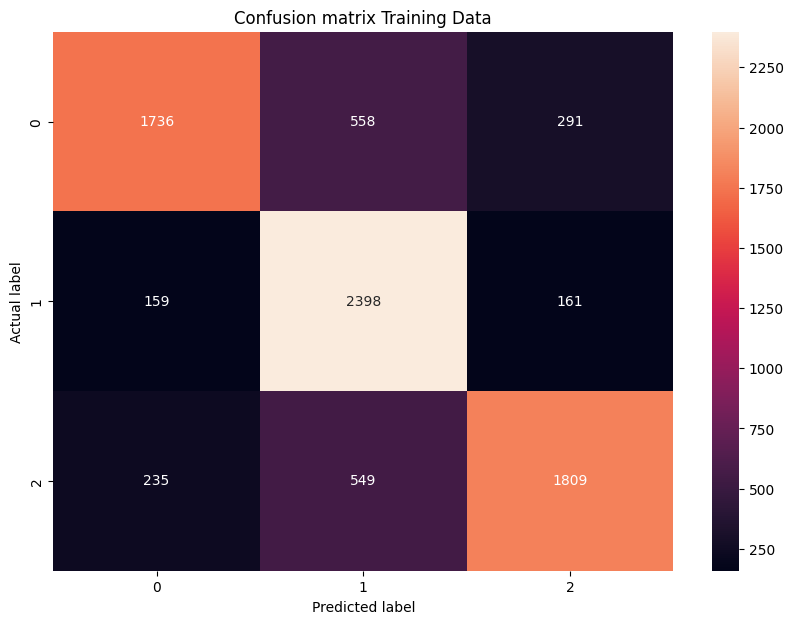

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_train_pred = model.predict([X_train_map, X_train_momentum, X_train_refractive_index])

# Convert the predictions from categorical back to original labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_train_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Training Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


62/62 [==============================] - 1s 9ms/step


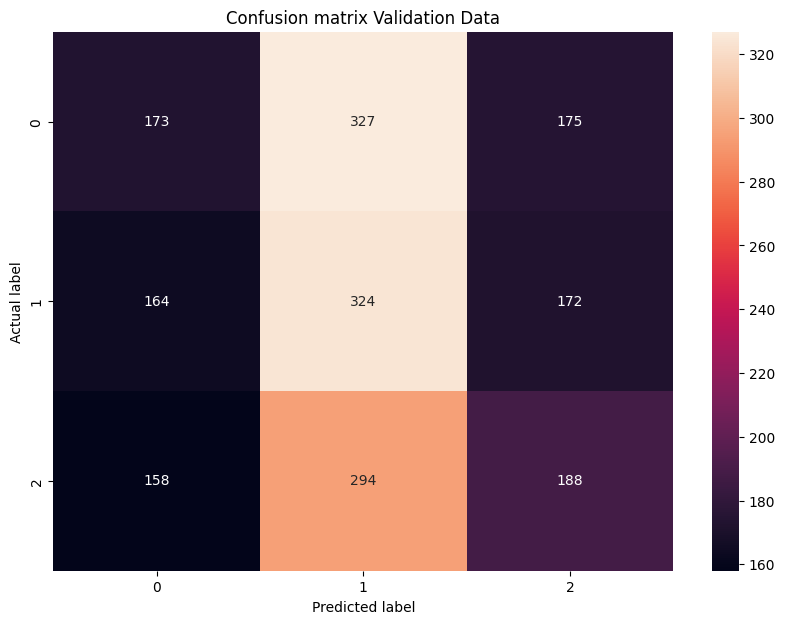

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_val_pred = model.predict([X_test_map, X_test_momentum, X_test_refractive_index])

# Convert the predictions from categorical back to original labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_val_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Validation Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [11]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, concatenate

class ParticleDataUtils:
    class ParticleInfo:
        def __init__(self, momentum, mass, energy, refractiveIndex, ckov, filledBins):
            self.momentum = momentum
            self.mass = mass
            self.energy = energy
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins

def save_particle_info_to_hdf5(particle_vector, filename):
    with h5py.File(filename, 'w') as file:
        for i, particle in enumerate(particle_vector):
            # Create a group for each particle
            group = file.create_group(f'Particle{i}')

            # Store scalar values
            group.attrs['Momentum'] = particle.momentum
            group.attrs['Mass'] = particle.mass
            group.attrs['Energy'] = particle.energy
            group.attrs['RefractiveIndex'] = particle.refractiveIndex
            group.attrs['Ckov'] = particle.ckov



            # Store filledBins to HDF5 file
            group.create_dataset("FilledBins", data=np.array(particle.filledBins, dtype=[('x', 'f'), ('y', 'f')]))

def load_particle_info_from_hdf5(filename):
    particle_vector = []
    
    with h5py.File(filename, 'r') as file:
        for i, group_name in enumerate(file):
            group = file[group_name]

            # Read scalar values
            momentum = group.attrs['Momentum']
            mass = group.attrs['Mass']
            energy = group.attrs['Energy']
            refractiveIndex = group.attrs['RefractiveIndex']
            ckov = group.attrs['Ckov']

            # Read filledBins
            filled_bins_dataset = group['FilledBins']
            filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

            filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

            particle_info = ParticleDataUtils.ParticleInfo(
                momentum, mass, energy, refractiveIndex, ckov, filledBins=filled_bins)
            
            particle_vector.append(particle_info)

    return particle_vector

def read_particle_data_from_file(filename="particle.h5"):
    drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
    file_path = os.path.join(drive_path, filename)
    particle_vector = load_particle_info_from_hdf5(file_path)
    return particle_vector

# Example usage
filename = 'ParticleInfo.h5'
particle_vector = read_particle_data_from_file(filename)

# Prepare the training data
X_train_map = [np.array(particle.filledBins) for particle in particle_vector]  # Convert to list of arrays
X_train_momentum = np.array([particle.momentum for particle in particle_vector])
X_train_refractive_index = np.array([particle.refractiveIndex for particle in particle_vector])
y_train = np.array([particle.mass for particle in particle_vector])

# Convert the NumPy arrays to TensorFlow tensors
X_train_map = [tf.convert_to_tensor(arr) for arr in X_train_map]  # Convert to list of TensorFlow tensors
X_train_momentum = tf.convert_to_tensor(X_train_momentum)
X_train_refractive_index = tf.convert_to_tensor(X_train_refractive_index)
y_train = tf.convert_to_tensor(y_train)

# Define input shapes
map_shape = (160, 144, 2)  # 160 x pads [0..159] | 144 y pads [0..143] | 2D bin values
momentum_shape = (1,)  # Scalar input
refractive_index_shape = (1,)  # Scalar input

# Define inputs
map_input = Input(shape=map_shape, name='map_input')
momentum_input = Input(shape=momentum_shape, name='momentum_input')
refractive_index_input = Input(shape=refractive_index_shape, name='refractive_index_input')

# Define convolutional layers for the map input
conv1 = Conv2D(32, (3, 3), activation='relu')(map_input)
conv2 = Conv2D(32, (3, 3), activation='relu')(conv1)
conv3 = Conv2D(32, (3, 3), activation='relu')(conv2)
flat_map = Flatten()(conv3)

# Concatenate map features with other inputs
concat = concatenate([flat_map, momentum_input, refractive_index_input])

# Define fully connected layers
fc1 = Dense(128, activation='relu')(concat)
fc2 = Dense(64, activation='relu')(fc1)
output = Dense(1, activation='linear')(fc2)  # Predicting mass as a scalar value

# Define the model
model = Model(inputs=[map_input, momentum_input, refractive_index_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
